# Lab: using clustering to find best store locations

Imagine the following situation:<br>
You own a pizza chain, and you collected data about pizza deliveries in a certain neighborhood. The data contains a coordinate of each delivery as a pair *(Latitude, Longitude)*. You do not have any stores in this neighborhood, and driving there each time is too expensive (especially with current gas prices). So you decide to open $K$ new stores in this area. The task is, based on the frequent delivery data, determine the best locations for the new stores.

You need to perform the $K$-means clustering of delivery locations, and otput the best location for $K$ new stores. How would you choose the location of the store within each cluster that minimizes the overall distance between the store and each delivery address? __Explain your idea in a separate cell below.__

The data is 2-dimensional and it is easy to plot it to see if the locations of new stores make sense.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import pandas as pd
import numpy as np
from math import sqrt
import random

The data is a real data collected by [this person](https://github.com/angelddaz) while they were working as a pizza delivery driver. The file `pizza_delivery_locations.csv` is a projection of the original data and contains only *(Latitude, Longitude)* of each delivery address. 

In [2]:
data_file = "pizza_delivery_locations.csv"

In [3]:
data = pd.read_csv(data_file)
print(data.columns)
len(data)

# convert dataframe to a 2D numpy array - it is easier to work with it
data = data.to_numpy()

Index(['Latitude', 'Longitude'], dtype='object')


## Task 1.

Use $K$-means clustering algorithm to find the best locations for new pizza stores for $K$=2, $K$=3 and $K$=4. The answers should be represented as lists of *(Latitide,Longitude)* tuples for each value of $K$.

You can use the custom code from the k-means demo, or you can implement your own clustering algorithm. What distance metric is the most appropriate for this situation?

Ironically, I actually am a pizza delivery driver, and I can tell you for a fact that *in practice*, I wouldn't choose euclidean distance. However, to get a real idea about which addresses should be assigned to which stores, there's a lot of other data we'd need other than simple location. Traffic buildup data, street orientation, etc. We'd probably really want to use a combination of A* pathfinding (or some weighted edge graph algorithm) and a clustering algorithm. I think in reality, most stores *do* use something like euclidean distance, unfortunately.

That being said, for the purpose of this assignment, euclidean distance is probably the best. We just want to get these stores as close to the center of these nodes in terms of pure distance as possible. We can take the centroids as the best locations for the stores.

In [4]:
# euclidean distance from demo
def euclidean(v1,v2):
    res=0
    dimensions=min(len(v1),len(v2))
    for i in range(dimensions):
        res+=pow(abs(v1[i]-v2[i]),2)

    return sqrt(float(res))

In [5]:
# k-means clustering code from the demo
# k-means clustering
def kcluster(rows,distance=euclidean,k=4):
    # Determine the minimum and maximum values for each point
    ranges=[(min([row[i] for row in rows]),max([row[i] for row in rows]))
    for i in range(len(rows[0]))]

    # Create k randomly placed centroids
    clusters=[[random.random()*(ranges[i][1]-ranges[i][0])+ranges[i][0]
                            for i in range(len(rows[0]))] for j in range(k)]
  
    lastmatches=None
    bestmatches = None

    for t in range(100):
        print ('Iteration %d' % t)
        bestmatches=[[] for i in range(k)]
    
        # Find which centroid is the closest for each row
        for j in range(len(rows)):
            row=rows[j]
            bestmatch=0
            for i in range(k):
                d=distance(clusters[i],row)
                if d<distance(clusters[bestmatch],row): bestmatch=i
            bestmatches[bestmatch].append(j)

        # If the results are the same as last time, this is complete
        if bestmatches==lastmatches: break
        lastmatches=bestmatches
    
        # Move the centroids to the average of the cluster members
        for i in range(k):
            avgs=[0.0]*len(rows[0])
            if len(bestmatches[i])>0:
                for rowid in bestmatches[i]:
                    for m in range(len(rows[rowid])):
                        avgs[m]+=rows[rowid][m]
                for j in range(len(avgs)):
                    avgs[j]/=len(bestmatches[i])
                clusters[i]=avgs
      
    return bestmatches

In [6]:
# clustering code for 2,3 and 4 clusters
k2 = kcluster(data, distance = euclidean, k=2)
k3 = kcluster(data, distance = euclidean, k=3)
k4 = kcluster(data, distance = euclidean, k=4)

display(data)
display(k2[1])

Iteration 0
Iteration 1
Iteration 0
Iteration 1
Iteration 2
Iteration 0
Iteration 1
Iteration 2


array([[  43.666573, -116.263356],
       [  43.652722, -116.259743],
       [  43.624462, -116.21835 ],
       ...,
       [  43.652722, -116.259743],
       [  43.648076, -116.23413 ],
       [  43.659428, -116.231891]])

[10,
 29,
 36,
 57,
 58,
 84,
 88,
 103,
 107,
 132,
 194,
 213,
 247,
 529,
 576,
 637,
 646,
 656,
 664,
 721,
 803,
 909,
 921,
 935,
 1020,
 1069,
 1104,
 1216,
 1218,
 1220,
 1247,
 1251,
 1283,
 1292]

Given this, it should be pretty easy to use the clusters to find the most central location for each cluster. Let's do that first:

In [7]:
# then we should find the centeroids of each cluster

def find_centers(clusters, data):
    centers = [
        [sum(data[point][0] for point in cluster) / len(cluster),
         sum(data[point][1] for point in cluster) / len(cluster)]
        for cluster in clusters
    ]
    return centers

k2_centers = find_centers(k2, data)
k3_centers = find_centers(k3, data)
k4_centers = find_centers(k4, data)

display(k2_centers)
display(k3_centers)
display(k4_centers)

[[43.64674992107355, -116.24003388397858],
 [43.72387899999997, -116.25504600000009]]

[[43.72387899999997, -116.25504600000009],
 [43.63727286046531, -116.22524744798069],
 [43.663956051111185, -116.2668794800005]]

[[43.72387899999997, -116.25504600000009],
 [43.663956051111185, -116.2668794800005],
 [43.64181413317214, -116.24036592978175],
 [43.63263042079218, -116.2097921683169]]

## Task 2
Visualize clusters by plotting each data point and coloring it with a different color corresponding to the cluster to which it belongs. Also plot the locations of new stores for each value of $K$. Some examples of the final visualizations are given below.

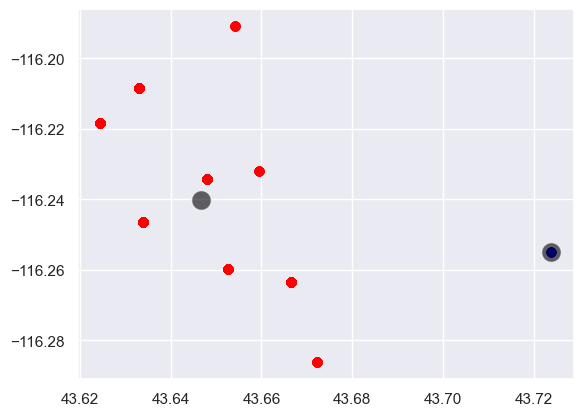

In [8]:
# plot function!

def plot_clusters(clusters, data, centers):
    plt.figure()
    
    colors = ['red', 'blue', 'green', 'yellow']
    center_color = 'black'
    
    for i, index in enumerate(clusters):
        cluster_data = data[index]
        
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], color=colors[i])
        plt.scatter(centers[i][0], centers[i][1], color=center_color, alpha=0.6, edgecolor='white', s=200)
        
    plt.show()
    
plot_clusters(k2, data, k2_centers)

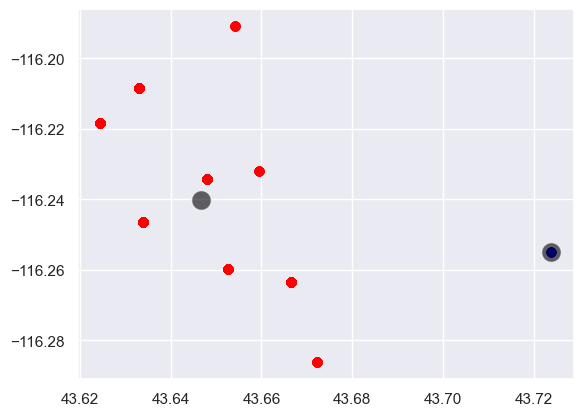

In [9]:
plot_clusters(k2, data, k2_centers)

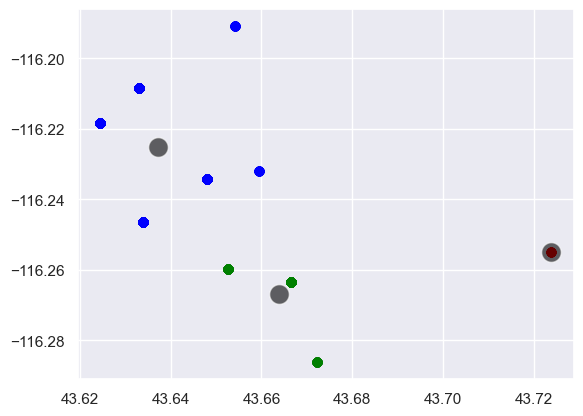

In [10]:
plot_clusters(k3, data, k3_centers)

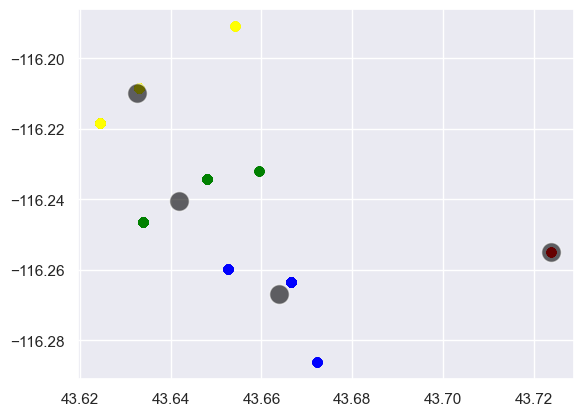

In [11]:
plot_clusters(k4, data, k4_centers)

## Examples of cluster visualization in 2D

Plotting original data:
    
<img src="clusters.png">

Plotting clusters with store locations
<img src="locations.png">

Copyright &copy; 2024 Marina Barsky. All rights reserved.